In [1]:
from variability import calculate_indicators
from utils import load_pickle_file
import pickle
import matplotlib.pyplot as plt
from sklearn import manifold
from matplotlib import cm
from matplotlib.lines import Line2D
import numpy as np

In [2]:
import zipfile
import csv
import ast
import numpy as np

def find_all_simulation_folders(ti_pct, num_shape, ti_aux_var, seed=[852,123,456,789,254,648], zip_path=r'K:\CET\Resultats\results.zip', output_dir=None):
    aux_var_str = ",".join(sorted(ti_aux_var.split(",")))  # Normalise les variables
    matched_folders = []

    seeds = [str(sd) for sd in seed]

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        # Tous les dossiers output_mps_clf_
        folders = [f for sd in seeds for f in zipf.namelist() if f.startswith('output_mps_clf_') and f.endswith(sd + '/')]

        for folder in folders:
            log_path = folder + 'deesse_output/simulation_log.csv'
            try:
                with zipf.open(log_path) as log_file:
                    reader = csv.DictReader((line.decode('utf-8') for line in log_file))
                    for row in reader:
                        try:
                            row_aux_list = sorted(ast.literal_eval(row['auxTI_var']))
                            input_aux_list = sorted(ti_aux_var.split(","))
                        except Exception as e:
                            print(f"Erreur parsing auxTI_var : {row['auxTI_var']} — {e}")
                            continue

                        if (int(row['ti_pct_area']) == int(ti_pct)
                            and int(row['ti_nshapes']) == int(num_shape)
                            and row_aux_list == input_aux_list):
                            matched_folders.append(folder)
                            break
            except KeyError:
                continue
    return matched_folders
    # if matched_folders:
    #     # Choix du dossier de sortie
    #     if output_dir is None:
    #         # Dossier par défaut = un dossier temporaire
    #         extract_dir = os.path.join(os.getcwd(), f"mps_sim_{next(tempfile._get_candidate_names())}")
    #     else:
    #         # On utilise directement le dossier fourni
    #         extract_dir = os.path.abspath(output_dir)

    #     os.makedirs(extract_dir, exist_ok=True)

    #     with zipfile.ZipFile(zip_path, 'r') as zipf:
    #         for folder in matched_folders:
    #             for file in zipf.namelist():
    #                 if file.startswith(folder):
    #                     zipf.extract(file, extract_dir)

    #     # Construire la liste des chemins extraits
    #     extracted_paths = [os.path.join(extract_dir, f) for f in matched_folders]

    #     print("✅ Dossiers extraits :")
    #     for p in extracted_paths:
    #         print("   ", p)

    #     # Ouvre le dossier global qui contient tout
    #     subprocess.run(['explorer', os.path.realpath(extract_dir)], check=False)

    #     return extracted_paths
    # else:
    #     print("❌ Aucun dossier correspondant trouvé.")
    #     return []

In [ ]:
SEED_LIST=[852,123,456,789,254,
           #648,675,585,654,157
           ]
TI_PCT_AREA_LIST=[25,
                  55,
                  #75,
                  90]
NUM_SHAPE_LIST=[#1,
                5,
                10,
                15,
                50]
AUX_VARS_LIST=[
    "grid_grv",
    "grid_lmp",
    "grid_mag",
    "grid_grv,grid_lmp",
    "grid_grv,grid_mag",
    "grid_lmp,grid_mag",
    # "grid_grv,grid_lmp,grid_mag",
]

reference_folder = find_all_simulation_folders(
                    ti_pct=75,
                    num_shape=1,
                    ti_aux_var="grid_grv,grid_lmp,grid_mag",
                    seed=[852,123,456,789,254]
                )

compared_folders = []

for aux_var in AUX_VARS_LIST:
    matched_folders = find_all_simulation_folders(
                        ti_pct=75,
                        num_shape=1,
                        ti_aux_var=aux_var,
                        output_dir = r"K:\CET\Resultats\TEST",
                        seed=[852,123,456,789,254]
                    )

    compared_folders.extend(matched_folders)

deesse_outputs = []
with zipfile.ZipFile(r"K:\CET\Resultats\results.zip") as zip:
    for matched_folder in compared_folders:
        log_path = matched_folder + 'deesse_output/deesse_output.pkl'
        deesse_output = pickle.load(zip.open(log_path, mode='r'))
        deesse_outputs.append(deesse_output)
    for matched_folder in reference_folder:
        deesse_outputs.append(pickle.load(zip.open(matched_folder + 'deesse_output/deesse_output.pkl', mode='r')))





In [21]:
reference_folder = find_all_simulation_folders(
                    ti_pct=90,
                    num_shape=1,
                    ti_aux_var="grid_grv,grid_lmp,grid_mag",
                    seed=[852,123,456,789,254]
                )


*** Img object ***
name = ''
(nx, ny, nz) = (337, 529, 1) # number of cells along each axis
(sx, sy, sz) = (1.0, 1.0, 1.0) # cell size (spacing) along each axis
(ox, oy, oz) = (0.0, 0.0, 0.0) # origin (coordinates of bottom-lower-left corner)
nv = 1  # number of variable(s)
varname = ['grid_geo_real00000']
val: (1, 1, 529, 337)-array
*****


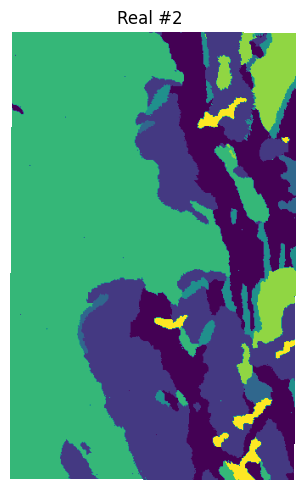

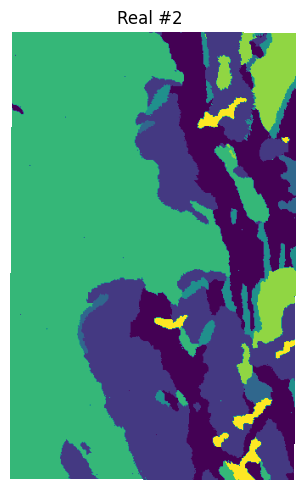

In [ ]:
from display_functions import plot_realizations
with zipfile.ZipFile(r"K:\CET\Resultats\results.zip") as z:
    deesse_output = pickle.load(z.open(reference_folder[1] + "deesse_output/deesse_output.pkl", mode='r'))
print(deesse_output["sim"][0])
plot_realizations(deesse_output, index_real=2)

print(deesse_output)

In [54]:
ent, dist_hist, dist_topo_hamming, dist_topo_lapl_spec = calculate_indicators(deesse_output=deesse_outputs, n_sim_variables=1, reference_var=np.array(0), use_reference=False)

In [60]:
np.save(r"K:\CET\Resultats\Analysis of results\ent_aux_var-31-6.npy", ent)

In [54]:
def plot_topological_adjacency(dist_topo_hamming, nsets=6, ngroups=6, referenceIsPresent=False, show=False, plot_size_factor=1):
    """
    Plots a 2D MDS representation of topological adjacency
    with nsets of 10 simulations each, distributed evenly across ngroups of colormaps.

    Parameters:
    -----------
    dist_topo_hamming : ndarray
        Precomputed topological adjacency (Hamming distance) matrix of shape (nsim, nsim) or (nsim+1, nsim+1).
    nsets : int
        Total number of sets of 10 simulations each.
    ngroups : int
        Number of colormap groups (max 6). Each group has the same number of sets.
    referenceIsPresent : bool, optional
        If True, includes the reference point in the plot.
    show : bool, optional
        If True, displays the plot immediately.
    """
    assert ngroups <= 6, "ngroups cannot be more than 6"
    if referenceIsPresent:
        assert (nsets-1) % ngroups == 0, "nsets must be divisible by ngroups"
    else:
        assert nsets % ngroups == 0, "nsets must be divisible by ngroups"

    plt.clf()
    plt.close()

    base_size = (8, 6)  
    plt.figure(figsize=(base_size[0] * plot_size_factor, base_size[1] * plot_size_factor))

    # MDS
    mds = manifold.MDS(n_components=2,
                       max_iter=3000,
                       eps=1e-9,
                       dissimilarity='precomputed',
                       random_state=852,
                       n_jobs=1)
    mds_positions = mds.fit_transform(dist_topo_hamming)

    # Define colormap pool
    cmap_pool = ['Greens', 'Oranges', 'Blues','Purples', 'Reds','Greys']
    
    # Define transparency values for each colormap (same order as cmap_pool)
    alpha_pool = [0,0,0,0,0,1]

    selected_cmaps = cmap_pool[:ngroups]
    selected_alphas = alpha_pool[:ngroups]

    # Sets per group
    if referenceIsPresent:
        sets_per_group = (nsets-1) // ngroups
    else:
        sets_per_group = nsets // ngroups

    # Assign colors
    colors = []
    for grp_idx in range(ngroups):
        cmap = cm.get_cmap(selected_cmaps[grp_idx])
        alpha_val = selected_alphas[grp_idx]
        if selected_cmaps[grp_idx] == "Purples":
            color_positions = np.linspace(0.3, 1, sets_per_group)
        else:
            color_positions = np.linspace(0.3, 1, sets_per_group)
        for i in range(sets_per_group):
            r, g, b, _ = cmap(color_positions[i])
            group_color = (r, g, b, alpha_val)  # add transparency
            colors.extend([group_color] * 10)  # each set has 10 simulations

    # plt.title('2D MDS Representation of Histogram Distances')
    plt.title('2D MDS Representation of Topological Adjacency (Hamming)')

    if referenceIsPresent:
        plt.scatter(mds_positions[:-50, 0], mds_positions[:-50, 1], c=colors, s=50, marker='x', label='Simulations Hamming')
        plt.scatter(mds_positions[-50:-1, 0], mds_positions[-50:-1, 1], c='red', s=50, marker='o', label='Reference Hamming')
    else:
        plt.scatter(mds_positions[:, 0], mds_positions[:, 1], c=colors, s=30, marker='x', label='Simulations Hamming')
        
    rangex = np.max(mds_positions[:, 0]) - np.min(mds_positions[:, 0])
    rangey = np.max(mds_positions[:, 1]) - np.min(mds_positions[:, 1])
    plt.xlim(np.min(mds_positions[:, 0]) - 0.1*rangex, np.max(mds_positions[:, 0]) + 0.1*rangex)
    plt.ylim(np.min(mds_positions[:, 1]) - 0.1*rangey, np.max(mds_positions[:, 1]) + 0.1*rangey)

    # legend_elements = [
    #     Line2D([0], [0], marker='x', color='w', label="25 %", markerfacecolor='green', markeredgecolor='green', markersize=8),
    #     Line2D([0], [0], marker='x', color='w', label='50 %', markerfacecolor='orange', markeredgecolor='orange', markersize=8),
    #     Line2D([0], [0], marker='x', color='w', label='90 %', markerfacecolor='blue', markeredgecolor='blue', markersize=8),
    # ]

    # legend_elements = [
    #     Line2D([0], [0], marker='x', color='w', label="5", markerfacecolor='green', markeredgecolor='green', markersize=8),
    #     Line2D([0], [0], marker='x', color='w', label='10', markerfacecolor='orange', markeredgecolor='orange', markersize=8),
    #     Line2D([0], [0], marker='x', color='w', label='15', markerfacecolor='blue', markeredgecolor='blue', markersize=8),
    #     Line2D([0], [0], marker='x', color='w', label='50', markerfacecolor='purple', markeredgecolor='purple', markersize=8),
    # ]

    legend_elements = [
        Line2D([0], [0], marker='x', color='w', label="Gravity anomaly", markerfacecolor='green', markeredgecolor='green', markersize=8),
        Line2D([0], [0], marker='x', color='w', label='Gravity first derivative', markerfacecolor='orange', markeredgecolor='orange', markersize=8),
        Line2D([0], [0], marker='x', color='w', label='Magnetic anomaly', markerfacecolor='blue', markeredgecolor='blue', markersize=8),
        Line2D([0], [0], marker='x', color='w', label='Gravity anomaly & Gravity first derivative', markerfacecolor='purple', markeredgecolor='purple', markersize=8),
        Line2D([0], [0], marker='x', color='w', label='Gravity anomaly & Magnetic anomaly', markerfacecolor='red', markeredgecolor='red', markersize=8),
        Line2D([0], [0], marker='x', color='w', label='Magnetic anomaly & Gravity first derivative', markerfacecolor='grey', markeredgecolor='grey', markersize=8)
    ]

    if referenceIsPresent:
        # legend_elements.append(
        #     Line2D([0], [0], marker='o', color='w', label='Reference (75%)', markerfacecolor='red', markeredgecolor='red', markersize=8)
        # )
        # legend_elements.append(
        #     Line2D([0], [0], marker='o', color='w', label='Reference (1)', markerfacecolor='red', markeredgecolor='red', markersize=8)
        # )
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', label='Reference (Gravity anomaly & Gravity first derivative & Magnetic anomaly)', markerfacecolor='red', markeredgecolor='red', markersize=8)
        )

    # plt.legend(handles=legend_elements, title="Auxiliary variable used", loc='best')



    plt.tight_layout()

    if show:
        plt.show()
    
    return


C:\Users\Axel (Travail)\AppData\Local\Temp\ipykernel_30660\4214601574.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(selected_cmaps[grp_idx])


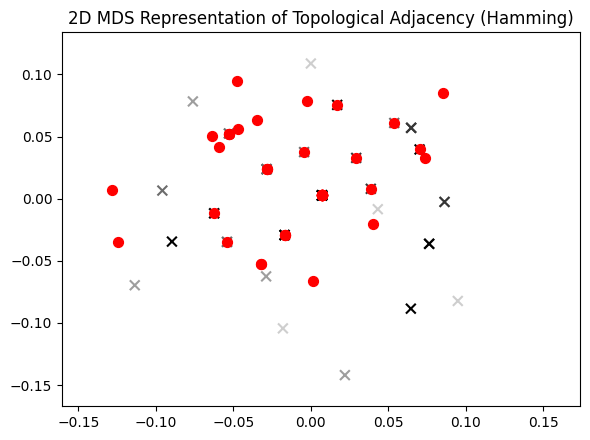

In [56]:
suffix = "aux_var-31-6"
ent, dist_hist, dist_topo_hamming = np.load("K:\CET\Resultats\Analysis of results\ent_"+suffix+".npy"),np.load("K:\CET\Resultats\Analysis of results\dist_hist_"+suffix+".npy"), np.load("K:\CET\Resultats\Analysis of results\dist_topo_hamming_"+suffix+".npy")
plot_topological_adjacency(dist_topo_hamming, nsets=31, ngroups=6, referenceIsPresent=True, show=False, plot_size_factor=0.75)